# Random Code Comparison

The point of this notebook is to experiment with different methods for generating random codes and see if any are different from each other or better or worse in some way. The three methods are projected haar random codes, expanded haar random codes, and two-expanded haar random codes. Projected codes takes a full haar random state with a physical dimension that matches the fock dimension of the physical system, and then projects it onto the logical zero and one subspaces for rotation-code encodings. Expanded haar random codes generates a haar random state with as many dimensions are used in the logical zero and one encodings, and then those levels are filled out with the random state's amplitudes. Two-expanded haar random codes are the same, but a different random state is used to fill out the logical zero and logical one encodings. Projected haar random codes were used for my senior thesis. There is no formal way to compare these codes, and distributions of points on the graphs were just eyeballed to look for patterns and trends. There is a lot more work that could be done to figure out how to compare quantum error correcting codes, especially two random codes.

Projected haar random codes and two-expanded haar random codes are seemingly the same in terms of performance. They don't seem to be much different as far as I can tell. As for expanded haar random codes, it seems like their optimal fidelities follow some sort of curve. This would imply to me that having the same amplitudes and shifted distributions for the logical zero and one encodings fixes that encoding's error correcting capabilities based on the encoding's average photon number. There is a lot more work that could be done to identify why/how the curve is being created.

### Imports

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import qutip as qt
from src import code_simulator, code, noise

### Parameters

In [2]:
rotation_symmetries = [2, 3, 4]
loss_noise_values = [0.1, 0.05, 0.03, 0.01]
average_photon_numbers = range(1, 4)
number_of_random_code_trials = 80

### Fidelities of Trivial Code

In [3]:
trivial_fidelities = [code_simulator.get_fidelity_of(code.trivial_code, noise.Noise(2, [("loss", loss_noise_amount)]), False) for loss_noise_amount in loss_noise_values]

### Fidelities of Binomial Code

This will take forever to run on the first time because it needs to calculate a lot of stuff, but subsequent runs should be near instantaneous because all the calculation values are saved to files.

In [4]:
%%time

binomial_fidelities = np.zeros((len(rotation_symmetries), len(loss_noise_values), len(average_photon_numbers), 2))
binomial_photon_numbers = np.zeros((len(rotation_symmetries), len(average_photon_numbers)))
for i, rotation_symmetry in enumerate(rotation_symmetries):
	for j, loss_noise_amount in enumerate(loss_noise_values):
		for k, average_photon_number in enumerate(average_photon_numbers):
			dimension = (average_photon_number + 2) * rotation_symmetry
			loss_noise = noise.Noise(dimension, [("loss", loss_noise_amount)])
			binomial_code = code.get_binomial_code(rotation_symmetry, average_photon_number, dimension)
			binomial_fidelities[i,j,k,0] = code_simulator.get_fidelity_of(binomial_code, loss_noise, False)
			binomial_fidelities[i,j,k,1] = code_simulator.get_fidelity_of(binomial_code, loss_noise, True)
			binomial_photon_numbers[i,k] = qt.expect(qt.num(binomial_code.physical_dimension), 1 / 2 * (binomial_code.zero_encoding * binomial_code.zero_encoding.dag() + binomial_code.one_encoding * binomial_code.one_encoding.dag()))

CPU times: user 5.67 s, sys: 818 ms, total: 6.49 s
Wall time: 5.35 s


### Fidelities of Cat Code

This will take a bit to run on the first time, but will be near-instantaneous after.

In [5]:
%%time

coherent_state_values = range(1, average_photon_numbers[-1])
cat_fidelities = np.zeros((len(rotation_symmetries), len(loss_noise_values), len(coherent_state_values), 2))
cat_photon_numbers = np.zeros((len(rotation_symmetries), len(coherent_state_values)))
for i, rotation_symmetry in enumerate(rotation_symmetries):
	for j, loss_noise_amount in enumerate(loss_noise_values):
		for k, coherent_state_value in enumerate(coherent_state_values):
			dimension = max(int(coherent_state_value ** 2 + 2.2 * coherent_state_value) + 1, rotation_symmetry + 1)
			loss_noise = noise.Noise(dimension, [("loss", loss_noise_amount)])
			cat_code = code.get_cat_code(rotation_symmetry, coherent_state_value, 0, dimension)
			cat_fidelities[i,j,k,0] = code_simulator.get_fidelity_of(cat_code, loss_noise, False)
			cat_fidelities[i,j,k,1] = code_simulator.get_fidelity_of(cat_code, loss_noise, True)
			cat_photon_numbers[i,k] = qt.expect(qt.num(cat_code.physical_dimension), 1 / 2 * (cat_code.zero_encoding * cat_code.zero_encoding.dag() + cat_code.one_encoding * cat_code.one_encoding.dag()))

CPU times: user 2.62 s, sys: 1.31 s, total: 3.93 s
Wall time: 1.78 s


### Fidelities of Projected Haar Random Codes

This will probably always take a bit.

In [6]:
%%time

projected_haar_random_fidelities = np.zeros((len(rotation_symmetries), len(loss_noise_values), len(average_photon_numbers), number_of_random_code_trials, 2))
projected_haar_random_photon_numbers = np.zeros((len(rotation_symmetries), len(loss_noise_values), len(average_photon_numbers), number_of_random_code_trials))
for i, rotation_symmetry in enumerate(rotation_symmetries):
	for j, loss_noise_amount in enumerate(loss_noise_values):
		for k, average_photon_number in enumerate(average_photon_numbers):
			for l in range(number_of_random_code_trials):
				dimension = (average_photon_number + 2) * rotation_symmetry
				loss_noise = noise.Noise(dimension, [("loss", loss_noise_amount)])
				projected_haar_random_code = code.make_projected_haar_random_code(rotation_symmetry, average_photon_number, dimension)
				projected_haar_random_fidelities[i,j,k,l,0] = code_simulator.get_fidelity_of(projected_haar_random_code, loss_noise, False)
				projected_haar_random_fidelities[i,j,k,l,1] = code_simulator.get_fidelity_of(projected_haar_random_code, loss_noise, True)
				projected_haar_random_photon_numbers[i,j,k,l] = qt.expect(qt.num(projected_haar_random_code.physical_dimension), 1 / 2 * (projected_haar_random_code.zero_encoding * projected_haar_random_code.zero_encoding.dag() + projected_haar_random_code.one_encoding * projected_haar_random_code.one_encoding.dag()))

CPU times: user 10min 6s, sys: 1min 9s, total: 11min 15s
Wall time: 9min 24s


### Fidelities of Expanded Haar Random Codes

This will probably always take a bit.

In [7]:
%%time

expanded_haar_random_fidelities = np.zeros((len(rotation_symmetries), len(loss_noise_values), len(average_photon_numbers), number_of_random_code_trials, 2))
expanded_haar_random_photon_numbers = np.zeros((len(rotation_symmetries), len(loss_noise_values), len(average_photon_numbers), number_of_random_code_trials))
for i, rotation_symmetry in enumerate(rotation_symmetries):
	for j, loss_noise_amount in enumerate(loss_noise_values):
		for k, average_photon_number in enumerate(average_photon_numbers):
			for l in range(number_of_random_code_trials):
				dimension = (average_photon_number + 2) * rotation_symmetry
				loss_noise = noise.Noise(dimension, [("loss", loss_noise_amount)])
				expanded_haar_random_code = code.make_expanded_haar_random_code(rotation_symmetry, average_photon_number, dimension)
				expanded_haar_random_fidelities[i,j,k,l,0] = code_simulator.get_fidelity_of(expanded_haar_random_code, loss_noise, False)
				expanded_haar_random_fidelities[i,j,k,l,1] = code_simulator.get_fidelity_of(expanded_haar_random_code, loss_noise, True)
				expanded_haar_random_photon_numbers[i,j,k,l] = qt.expect(qt.num(expanded_haar_random_code.physical_dimension), 1 / 2 * (expanded_haar_random_code.zero_encoding * expanded_haar_random_code.zero_encoding.dag() + expanded_haar_random_code.one_encoding * expanded_haar_random_code.one_encoding.dag()))

CPU times: user 9min 11s, sys: 1min 9s, total: 10min 21s
Wall time: 8min 28s


### Fidelities of Two-Expanded Haar Random Codes

This will probably always take a bit.

In [8]:
%%time

two_expanded_haar_random_fidelities = np.zeros((len(rotation_symmetries), len(loss_noise_values), len(average_photon_numbers), number_of_random_code_trials, 2))
two_expanded_haar_random_photon_numbers = np.zeros((len(rotation_symmetries), len(loss_noise_values), len(average_photon_numbers), number_of_random_code_trials))
for i, rotation_symmetry in enumerate(rotation_symmetries):
	for j, loss_noise_amount in enumerate(loss_noise_values):
		for k, average_photon_number in enumerate(average_photon_numbers):
			for l in range(number_of_random_code_trials):
				dimension = (average_photon_number + 2) * rotation_symmetry
				loss_noise = noise.Noise(dimension, [("loss", loss_noise_amount)])
				two_expanded_haar_random_code = code.make_two_expanded_haar_random_code(rotation_symmetry, average_photon_number, dimension)
				two_expanded_haar_random_fidelities[i,j,k,l,0] = code_simulator.get_fidelity_of(two_expanded_haar_random_code, loss_noise, False)
				two_expanded_haar_random_fidelities[i,j,k,l,1] = code_simulator.get_fidelity_of(two_expanded_haar_random_code, loss_noise, True)
				two_expanded_haar_random_photon_numbers[i,j,k,l] = qt.expect(qt.num(two_expanded_haar_random_code.physical_dimension), 1 / 2 * (two_expanded_haar_random_code.zero_encoding * two_expanded_haar_random_code.zero_encoding.dag() + two_expanded_haar_random_code.one_encoding * two_expanded_haar_random_code.one_encoding.dag()))

CPU times: user 10min 4s, sys: 1min 18s, total: 11min 23s
Wall time: 9min 12s


### Plots of Error Rates vs. Average Number

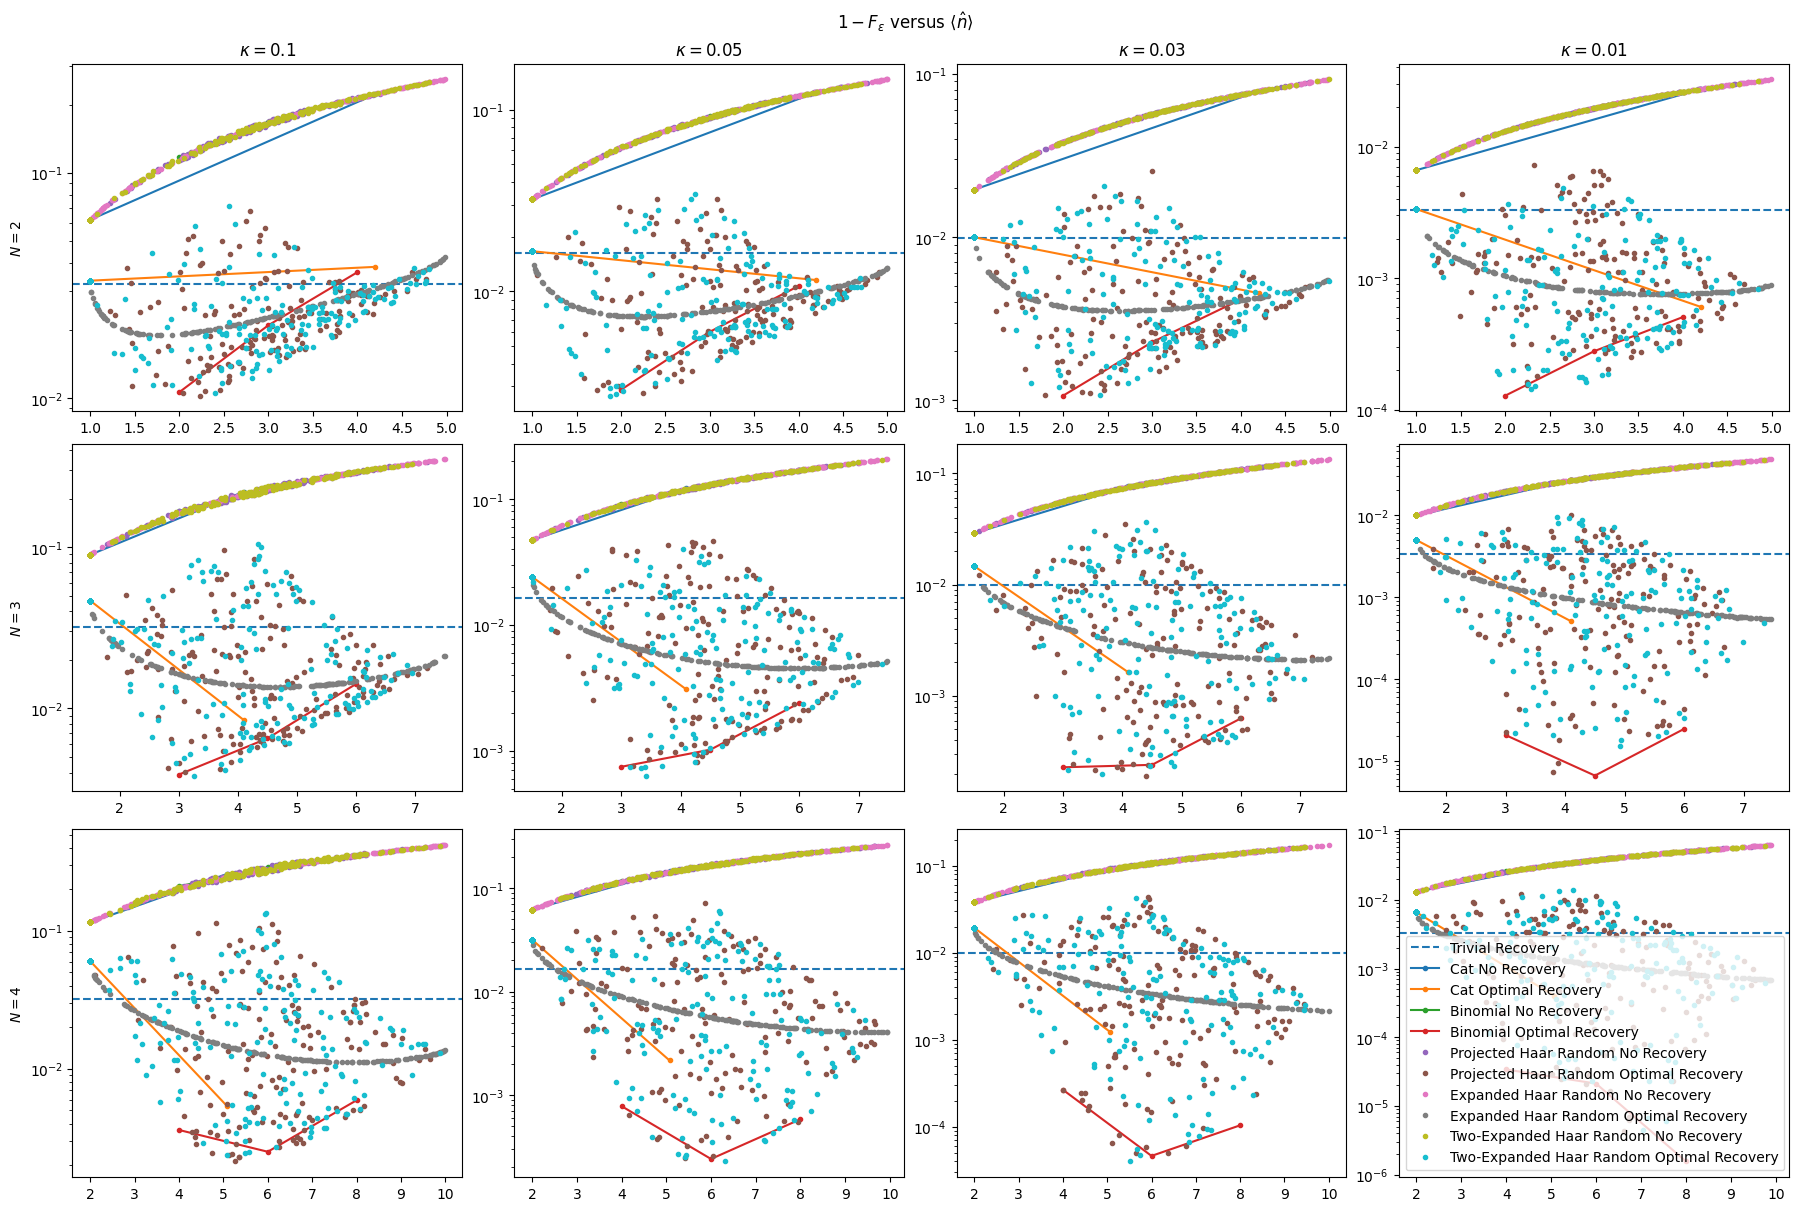

In [9]:
fig, axs = plt.subplots(len(rotation_symmetries), len(loss_noise_values), figsize=(18, 12), constrained_layout=True)
fig.suptitle(r"$1 - F_\epsilon$ versus $\langle\hat{n}\rangle$")
for i, rotation_symmetry in enumerate(rotation_symmetries):
	axs[i,0].set_ylabel(f"$N={rotation_symmetry}$")
for i, loss_noise_amount in enumerate(loss_noise_values):
	axs[0,i].set_title(f"$\\kappa={loss_noise_amount}$")

largest_x_limits = [float("infinity"), -float("infinity")]
largest_y_limits = [float("infinity"), -float("infinity")]
for i, rotation_symmetry in enumerate(rotation_symmetries):
	for j, loss_noise_amount in enumerate(loss_noise_values):
		axs[i,j].axhline(1 - trivial_fidelities[j], linestyle="--", label="Trivial Recovery")
		axs[i,j].semilogy(cat_photon_numbers[i], 1 - cat_fidelities[i,j,:,0], ".-", label="Cat No Recovery")
		axs[i,j].semilogy(cat_photon_numbers[i], 1 - cat_fidelities[i,j,:,1], ".-", label="Cat Optimal Recovery")
		axs[i,j].semilogy(binomial_photon_numbers[i], 1 - binomial_fidelities[i,j,:,0], ".-", label="Binomial No Recovery")
		axs[i,j].semilogy(binomial_photon_numbers[i], 1 - binomial_fidelities[i,j,:,1], ".-", label="Binomial Optimal Recovery")
		axs[i,j].semilogy(projected_haar_random_photon_numbers[i,j,:,:].flatten(), 1 - projected_haar_random_fidelities[i,j,:,:,0].flatten(), ".", label="Projected Haar Random No Recovery")
		axs[i,j].semilogy(projected_haar_random_photon_numbers[i,j,:,:].flatten(), 1 - projected_haar_random_fidelities[i,j,:,:,1].flatten(), ".", label="Projected Haar Random Optimal Recovery")
		axs[i,j].semilogy(expanded_haar_random_photon_numbers[i,j,:,:].flatten(), 1 - expanded_haar_random_fidelities[i,j,:,:,0].flatten(), ".", label="Expanded Haar Random No Recovery")
		axs[i,j].semilogy(expanded_haar_random_photon_numbers[i,j,:,:].flatten(), 1 - expanded_haar_random_fidelities[i,j,:,:,1].flatten(), ".", label="Expanded Haar Random Optimal Recovery")
		axs[i,j].semilogy(two_expanded_haar_random_photon_numbers[i,j,:,:].flatten(), 1 - two_expanded_haar_random_fidelities[i,j,:,:,0].flatten(), ".", label="Two-Expanded Haar Random No Recovery")
		axs[i,j].semilogy(two_expanded_haar_random_photon_numbers[i,j,:,:].flatten(), 1 - two_expanded_haar_random_fidelities[i,j,:,:,1].flatten(), ".", label="Two-Expanded Haar Random Optimal Recovery")
		xlimits = axs[i,j].get_xlim()
		ylimits = axs[i,j].get_ylim()
		if xlimits[0] < largest_x_limits[0]:
			largest_x_limits[0] = xlimits[0]
		if xlimits[1] > largest_x_limits[1]:
			largest_x_limits[1] = xlimits[1]
		if ylimits[0] < largest_y_limits[0]:
			largest_y_limits[0] = ylimits[0]
		if ylimits[1] > largest_y_limits[1]:
			largest_y_limits[1] = ylimits[1]

axs[-1,-1].legend()
plt.show()

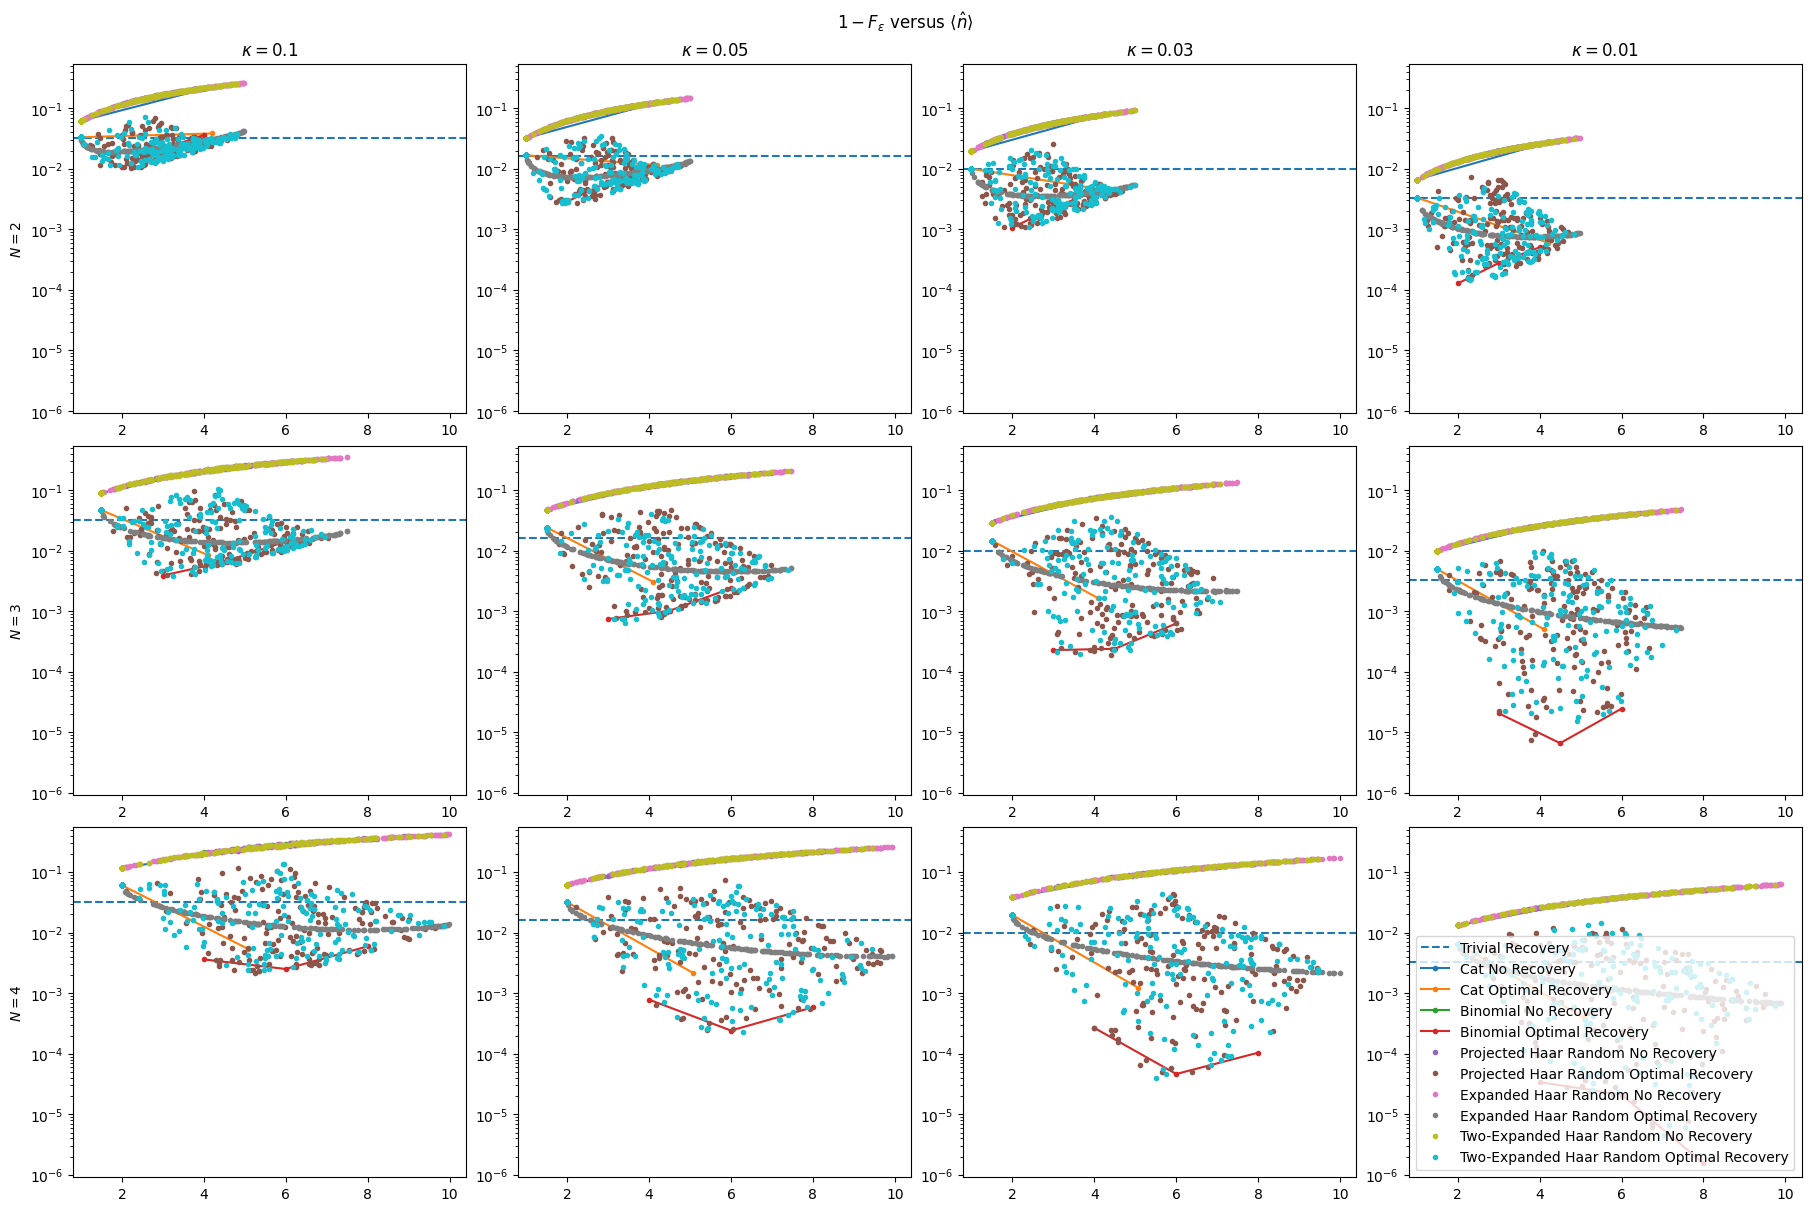

In [10]:
fig, axs = plt.subplots(len(rotation_symmetries), len(loss_noise_values), figsize=(18, 12), constrained_layout=True)
fig.suptitle(r"$1 - F_\epsilon$ versus $\langle\hat{n}\rangle$")
for i, rotation_symmetry in enumerate(rotation_symmetries):
	axs[i,0].set_ylabel(f"$N={rotation_symmetry}$")
for i, loss_noise_amount in enumerate(loss_noise_values):
	axs[0,i].set_title(f"$\\kappa={loss_noise_amount}$")

for i, rotation_symmetry in enumerate(rotation_symmetries):
	for j, loss_noise_amount in enumerate(loss_noise_values):
		axs[i,j].set_xlim(largest_x_limits)
		axs[i,j].set_ylim(largest_y_limits)
		axs[i,j].axhline(1 - trivial_fidelities[j], linestyle="--", label="Trivial Recovery")
		axs[i,j].semilogy(cat_photon_numbers[i], 1 - cat_fidelities[i,j,:,0], ".-", label="Cat No Recovery")
		axs[i,j].semilogy(cat_photon_numbers[i], 1 - cat_fidelities[i,j,:,1], ".-", label="Cat Optimal Recovery")
		axs[i,j].semilogy(binomial_photon_numbers[i], 1 - binomial_fidelities[i,j,:,0], ".-", label="Binomial No Recovery")
		axs[i,j].semilogy(binomial_photon_numbers[i], 1 - binomial_fidelities[i,j,:,1], ".-", label="Binomial Optimal Recovery")
		axs[i,j].semilogy(projected_haar_random_photon_numbers[i,j,:,:].flatten(), 1 - projected_haar_random_fidelities[i,j,:,:,0].flatten(), ".", label="Projected Haar Random No Recovery")
		axs[i,j].semilogy(projected_haar_random_photon_numbers[i,j,:,:].flatten(), 1 - projected_haar_random_fidelities[i,j,:,:,1].flatten(), ".", label="Projected Haar Random Optimal Recovery")
		axs[i,j].semilogy(expanded_haar_random_photon_numbers[i,j,:,:].flatten(), 1 - expanded_haar_random_fidelities[i,j,:,:,0].flatten(), ".", label="Expanded Haar Random No Recovery")
		axs[i,j].semilogy(expanded_haar_random_photon_numbers[i,j,:,:].flatten(), 1 - expanded_haar_random_fidelities[i,j,:,:,1].flatten(), ".", label="Expanded Haar Random Optimal Recovery")
		axs[i,j].semilogy(two_expanded_haar_random_photon_numbers[i,j,:,:].flatten(), 1 - two_expanded_haar_random_fidelities[i,j,:,:,0].flatten(), ".", label="Two-Expanded Haar Random No Recovery")
		axs[i,j].semilogy(two_expanded_haar_random_photon_numbers[i,j,:,:].flatten(), 1 - two_expanded_haar_random_fidelities[i,j,:,:,1].flatten(), ".", label="Two-Expanded Haar Random Optimal Recovery")

axs[-1,-1].legend()
plt.show()